In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from datetime import date, timedelta

import mechafil.data as mecha_data
import mechafil.data_spacescope as data_spacescope
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, setup_spacescope
from mechafil.power import (
    forecast_power_stats,
    build_full_power_stats_df,
    scalar_or_vector_to_vector,
    compute_day_se_power,
    compute_basic_day_renewed_power
)

import matplotlib.pyplot as plt

In [3]:
import jax
from jax import lax
import jax.numpy as jnp

In [4]:
setup_spacescope('/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json')
spacescope_obj = data_spacescope.SpacescopeDataConnection('/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json')

In [5]:
forecast_length = 360*5
start_date = date(2021, 3, 16)
current_date = date.today() - timedelta(days=2)
end_date = current_date + timedelta(days=forecast_length)

In [6]:
# Get sector scheduled expirations
res = get_sector_expiration_stats(start_date, current_date, end_date)
rb_known_scheduled_expire_vec = res[0]
qa_known_scheduled_expire_vec = res[1]
known_scheduled_pledge_release_full_vec = res[2]
# Get daily stats
fil_stats_df = get_historical_network_stats(start_date, current_date, end_date)
current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]
# Forecast power stats
rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

scheduled_df = spacescope_obj.query_spacescope_sector_expirations(start_date, end_date)

In [7]:
rr = 0.6
rbp = 10
duration = 360

renewal_rate_vec = rr * np.ones(forecast_length)
day_rb_onboarded_power = rbp * np.ones(forecast_length)

day_rb_scheduled_expire_power = np.zeros(forecast_length)
day_rb_renewed_power = np.zeros(forecast_length)

# the general case
rb_known_sched_expire_vec_truncated = rb_known_scheduled_expire_vec

In [8]:
%%time
# the traditional loop
for day_i in range(forecast_length):
    # Raw-power stats
    day_rb_scheduled_expire_power[day_i] = compute_day_se_power(
        day_i,
        rb_known_sched_expire_vec_truncated,
        day_rb_onboarded_power,
        day_rb_renewed_power,
        duration,
    )
    day_rb_renewed_power[day_i] = compute_basic_day_renewed_power(
        day_i, day_rb_scheduled_expire_power, renewal_rate_vec
    )

CPU times: user 1.54 ms, sys: 3 µs, total: 1.54 ms
Wall time: 1.54 ms


In [9]:
"""
def scan(f, init, xs, length=None):
    if xs is None:
         xs = [None] * length
    carry = init
    ys = []
    for x in xs:
        carry, y = f(carry, x)  # carry is the carryover
        ys.append(y)            # the `y`s get accumulated into a stacked array
    return carry, np.stack(ys)
"""

def basic_scalar_renewed_power(day_sched_expire_power, renewal_rate):
    return day_sched_expire_power * renewal_rate

def have_known_se_sector_info(arggs):
    known_scheduled_expire_vec, day_i = arggs
    return known_scheduled_expire_vec[day_i]

def dont_have_known_se_sector_info(arggs):
    return 0.0

def have_modeled_sector_expiration_info(arggs):
    day_onboard_vec, day_renewed_vec, day_i, duration = arggs
    return day_onboard_vec[day_i - duration] + day_renewed_vec[day_i - duration]

def dont_have_modeled_sector_expiration_info(arggs):
    return 0.0

def jax_compute_day_se_power(
    day_i,
    known_scheduled_expire_vec,
    day_onboard_vec,
    day_renewed_vec,
    duration,
):
    # Scheduled expirations coming from known active sectors
    pred = day_i > len(known_scheduled_expire_vec) - 1
    known_day_se_power = lax.cond(
        pred, 
        dont_have_known_se_sector_info,
        have_known_se_sector_info, 
        (known_scheduled_expire_vec, day_i)
     )
    
    pred = day_i - duration >= 0
    model_day_se_power = lax.cond(
        pred,
        have_modeled_sector_expiration_info,
        dont_have_modeled_sector_expiration_info,
        (day_onboard_vec, day_renewed_vec, day_i, duration)
    )
    
    # Total scheduled expirations
    day_se_power = known_day_se_power + model_day_se_power
    return day_se_power

In [10]:
#  1 - test that the function `jax_compute_day_se_power` works w/ a normal for-loop
day_rb_scheduled_expire_power_jax1 = np.zeros(forecast_length)
day_rb_renewed_power_jax1 = np.zeros(forecast_length)

for day_i in range(forecast_length):
    # Raw-power stats
    se_power_day_i = jax_compute_day_se_power(
        day_i,
        rb_known_sched_expire_vec_truncated,
        day_rb_onboarded_power,
        day_rb_renewed_power,
        duration,
    )
    renew_day_i = basic_scalar_renewed_power(
        se_power_day_i, renewal_rate_vec[day_i]
    )
    
    day_rb_scheduled_expire_power_jax1[day_i] = se_power_day_i
    day_rb_renewed_power_jax1[day_i] = renew_day_i

<IPython.core.display.Javascript object>


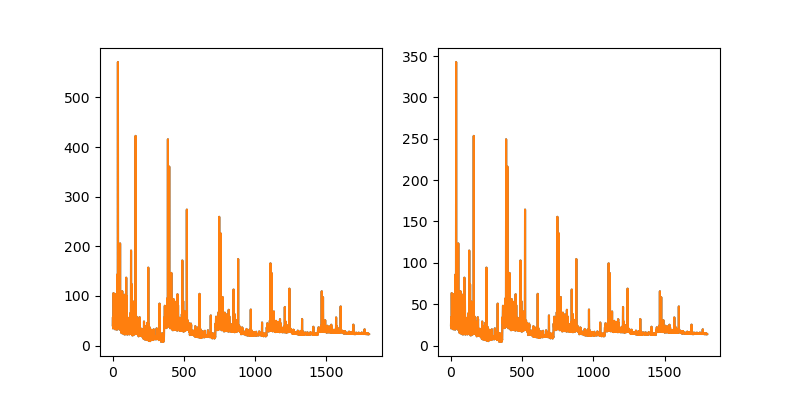

In [11]:
x = range(forecast_length)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(x, day_rb_scheduled_expire_power, label='mechaFIL')
plt.plot(x, day_rb_scheduled_expire_power_jax1, label='jax1')

plt.subplot(1,2,2)
plt.plot(x, day_rb_renewed_power, label='mechaFIL')
plt.plot(x, day_rb_renewed_power_jax1, label='jax1')


In [12]:
def compute_se(carry, x):
    # carry - result from previous loop
    # x - current array element
    
    day_rb_renewed_power_vec, day_i, duration = carry
    
    # compute the components of SE power
    
    # known SE
    pred = day_i > len(rb_known_sched_expire_vec_truncated) - 1
    known_day_se_power = lax.cond(
        pred, 
        dont_have_known_se_sector_info,
        have_known_se_sector_info, 
        (rb_known_sched_expire_vec_truncated, day_i)
     )
    
    pred = day_i - duration >= 0
    model_day_se_power = lax.cond(
        pred,
        have_modeled_sector_expiration_info,
        dont_have_modeled_sector_expiration_info,
        (day_rb_onboarded_power, day_rb_renewed_power_vec, day_i, duration)
    )
    day_se_power = known_day_se_power + model_day_se_power
    
    # compute new renewed power
    day_i_rb_renewed_power = day_se_power * rr
    #day_rb_renewed_power_vec[day_i] = day_i_rb_renewed_power
    day_rb_renewed_power_vec = day_rb_renewed_power_vec.at[day_i].set(day_i_rb_renewed_power)
    
    return (day_rb_renewed_power_vec, day_i+1, duration), day_se_power

In [13]:
#  2 - put it into a lax.scan formulation
day_rb_renewed_power_vec = jnp.zeros(len(day_rb_onboarded_power))
ret, day_rb_scheduled_expire_power_jax2 = lax.scan(compute_se, (day_rb_renewed_power_vec, 0, duration), None, length=forecast_length)
day_rb_renewed_power_jax2 = ret[0]

<IPython.core.display.Javascript object>


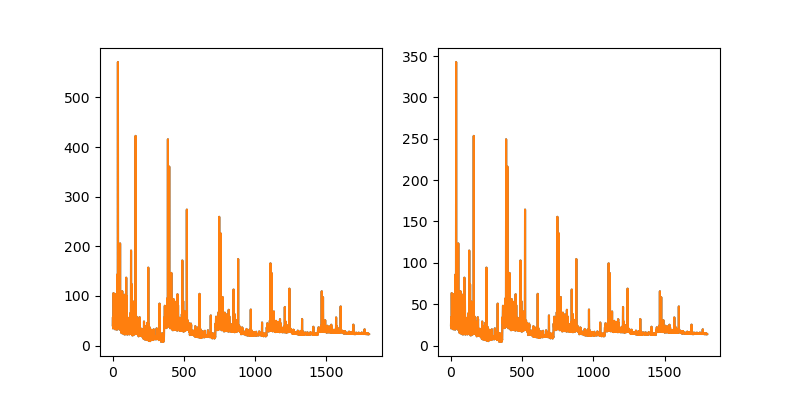

In [14]:
x = range(forecast_length)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(x, day_rb_scheduled_expire_power, label='mechaFIL')
plt.plot(x, day_rb_scheduled_expire_power_jax2, label='jax2')

plt.subplot(1,2,2)
plt.plot(x, day_rb_renewed_power, label='mechaFIL')
plt.plot(x, day_rb_renewed_power_jax2, label='jax2')

In [15]:
# jit compile the compute_se fucntion
compute_se_jit = jax.jit(compute_se)

In [16]:
%time 

day_rb_renewed_power_vec = jnp.zeros(len(day_rb_onboarded_power))
ret, day_rb_scheduled_expire_power_jax3 = lax.scan(compute_se_jit, (day_rb_renewed_power_vec, 0, duration), None, length=forecast_length)
day_rb_renewed_power_jax3 = ret[0]

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


<IPython.core.display.Javascript object>


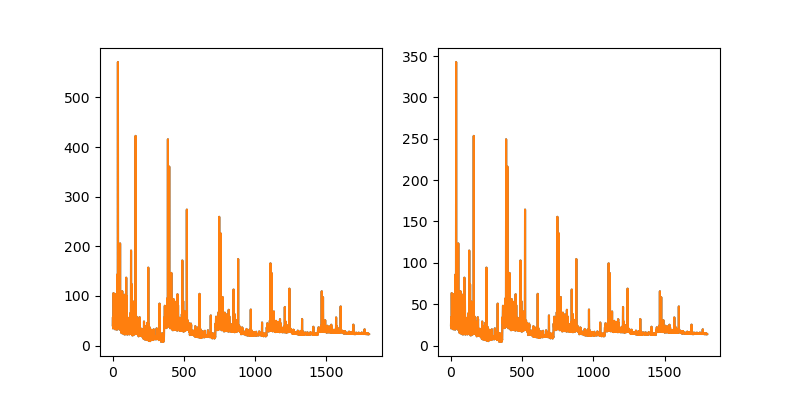

In [17]:
x = range(forecast_length)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(x, day_rb_scheduled_expire_power, label='mechaFIL')
plt.plot(x, day_rb_scheduled_expire_power_jax3, label='jax2')

plt.subplot(1,2,2)
plt.plot(x, day_rb_renewed_power, label='mechaFIL')
plt.plot(x, day_rb_renewed_power_jax3, label='jax2')